Jupyter notebook using conditional U-Net for creating 2D inelastic diffraction patterns from 2D elastic diffraction patterns.<br>
Written by Dasol Yoon, Desheng Ma, Hari KP, Schuyler Shi, and Zhaslan Baraissov from Cornell University<br>
Last edited on December 17th, 2024

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim

### import datasets

In [34]:
#import datasets
fpath = '/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/'
inputImg_dir = 'test/z2_29_26-x01.03-y01.05_noTDS_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5'
outputImg_dir = 'test/z2_29_26-x01.03-y01.05_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5'
label_data = np.load(fpath+'test_Z_map/z2_29_26-x01.03-y01.05.npy')

# # Load .npy file using numpy
# inputImg_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test/z1_4_33-x01.04-y00.82_noTDS_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5"
# outputImg_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test/z1_4_33-x01.04-y00.82_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5"
# label_data = np.load("/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test_Z_map/z1_4_33-x01.04-y00.82.npy")


In [35]:
dataNoTDS = h5py.File(fpath+inputImg_dir, 'r')
input_data = dataNoTDS['array'][:]  # Shape (real1, real2, diff1, diff2)

dataTDS = h5py.File(fpath+outputImg_dir, 'r')
output_data = dataTDS['array'][:]

In [36]:
def normalize(data):
    return (data - np.min(data))/(np.max(data) - np.min(data))

In [37]:
normInput = normalize(input_data)
normOutput = normalize(output_data)

In [38]:
mask = label_data>1 #0.1

# Convert numpy arrays to PyTorch tensors
input_tensor = torch.tensor(normInput[mask], dtype=torch.float32) #"elastic" diffraction patterns
output_tensor = torch.tensor(normOutput[mask], dtype=torch.float32) #inelastic diffraction patterns
label_tensor = torch.tensor(label_data[mask], dtype=torch.float32) #Z numbers (Spatially Gaussian covoluted)
# label_tensor.fill_(0)

# Check shapes
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")
print(f"Label tensor shape: {label_tensor.shape}")

Input tensor shape: torch.Size([649, 64, 64])
Output tensor shape: torch.Size([649, 64, 64])
Label tensor shape: torch.Size([649])


### define the model & helper functions

In [39]:
class ConditionalUNet(nn.Module):
    def __init__(self, img_channels=1, label_dim=1, output_channels=1):
        super(ConditionalUNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(img_channels + label_dim, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder
        self.dec3 = self.upconv_block(512 + 256, 256)
        self.dec2 = self.upconv_block(256 + 128, 128)
        self.dec1 = self.upconv_block(128 + 64, 64)

        # Final Output Layer
        self.final = nn.Conv2d(64, output_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block with two Conv2D layers and ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """Upsampling block with ConvTranspose2D and Conv2D."""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, img, label):
        """
        Forward pass for Conditional U-Net.

        Args:
        img (Tensor): 2D diffraction pattern of shape (B, 1, 64, 64).
        label (Tensor): Integer variable of shape (B, 1).

        Returns:
        Tensor: Generated 2D diffraction pattern of shape (B, 1, 64, 64).
        """
        # Expand label to match the input image size
        label_img = label.view(-1, 1, 1, 1).expand(-1, 1, img.shape[2], img.shape[3])

        # Combine input and label
        combined_input = torch.cat([img, label_img], dim=1)

        # Encoder Path
        enc1 = self.enc1(combined_input)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc3, 2))

        # Decoder Path with Correct Interpolation
        dec3 = self.dec3(torch.cat((F.interpolate(bottleneck, size=enc3.shape[2:], mode='bilinear', align_corners=False), enc3), dim=1))
        dec2 = self.dec2(torch.cat((F.interpolate(dec3, size=enc2.shape[2:], mode='bilinear', align_corners=False), enc2), dim=1))
        dec1 = self.dec1(torch.cat((F.interpolate(dec2, size=enc1.shape[2:], mode='bilinear', align_corners=False), enc1), dim=1))

        # Final Output
        final_output = self.final(dec1)

        # Ensure Output Size Matches Target (64x64)
        final_output = F.interpolate(final_output, size=(64, 64), mode='bilinear', align_corners=False)
        return final_output

In [40]:
class CustomDataset(Dataset):
    def __init__(self, input_data, label_data, output_data):
        self.input_data = input_data  # Shape (N, 64, 64)
        self.label_data = label_data  # Shape (N,)
        self.output_data = output_data  # Shape (N, 64, 64)

    def __len__(self):
        return self.input_data.shape[0]

    def __getitem__(self, idx):
        # Extract image, label, and target
        image = self.input_data[idx].unsqueeze(0)    # Shape (1, 64, 64)
        label = self.label_data[idx].view(1)        # Shape (1,)
        target = self.output_data[idx].unsqueeze(0) # Shape (1, 64, 64)

        return image, label.float(), target

# Create Dataset and DataLoader
dataset = CustomDataset(input_tensor, label_tensor, output_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [41]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


Epoch [1/100]: 100%|██████████| 65/65 [00:02<00:00, 32.35it/s, loss=0.0039] 


Epoch [1], Train Loss: 0.0040, Test Loss: 0.0039


Epoch [2/100]: 100%|██████████| 65/65 [00:01<00:00, 33.61it/s, loss=0.00277]


Epoch [2], Train Loss: 0.0032, Test Loss: 0.0026


Epoch [3/100]: 100%|██████████| 65/65 [00:01<00:00, 35.79it/s, loss=0.00112] 


Epoch [3], Train Loss: 0.0014, Test Loss: 0.0011


Epoch [4/100]: 100%|██████████| 65/65 [00:01<00:00, 34.93it/s, loss=0.00115] 


Epoch [4], Train Loss: 0.0011, Test Loss: 0.0010


Epoch [5/100]: 100%|██████████| 65/65 [00:01<00:00, 34.84it/s, loss=0.000812]


Epoch [5], Train Loss: 0.0010, Test Loss: 0.0010


Epoch [6/100]: 100%|██████████| 65/65 [00:01<00:00, 34.52it/s, loss=0.00103] 


Epoch [6], Train Loss: 0.0009, Test Loss: 0.0009


Epoch [7/100]: 100%|██████████| 65/65 [00:01<00:00, 35.17it/s, loss=0.000692]


Epoch [7], Train Loss: 0.0009, Test Loss: 0.0008


Epoch [8/100]: 100%|██████████| 65/65 [00:01<00:00, 35.11it/s, loss=0.00107] 


Epoch [8], Train Loss: 0.0009, Test Loss: 0.0008


Epoch [9/100]: 100%|██████████| 65/65 [00:01<00:00, 34.81it/s, loss=0.000676]


Epoch [9], Train Loss: 0.0008, Test Loss: 0.0007


Epoch [10/100]: 100%|██████████| 65/65 [00:01<00:00, 34.75it/s, loss=0.00127] 


Epoch [10], Train Loss: 0.0012, Test Loss: 0.0011


Epoch [11/100]: 100%|██████████| 65/65 [00:01<00:00, 34.77it/s, loss=0.000759]


Epoch [11], Train Loss: 0.0009, Test Loss: 0.0007


Epoch [12/100]: 100%|██████████| 65/65 [00:01<00:00, 34.86it/s, loss=0.000649]


Epoch [12], Train Loss: 0.0006, Test Loss: 0.0006


Epoch [13/100]: 100%|██████████| 65/65 [00:02<00:00, 32.04it/s, loss=0.000252]


Epoch [13], Train Loss: 0.0004, Test Loss: 0.0003


Epoch [14/100]: 100%|██████████| 65/65 [00:02<00:00, 31.66it/s, loss=0.000274]


Epoch [14], Train Loss: 0.0003, Test Loss: 0.0004


Epoch [15/100]: 100%|██████████| 65/65 [00:01<00:00, 32.65it/s, loss=0.00025] 


Epoch [15], Train Loss: 0.0003, Test Loss: 0.0003


Epoch [16/100]: 100%|██████████| 65/65 [00:02<00:00, 32.14it/s, loss=0.000193]


Epoch [16], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [17/100]: 100%|██████████| 65/65 [00:02<00:00, 32.11it/s, loss=0.000216]


Epoch [17], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [18/100]: 100%|██████████| 65/65 [00:01<00:00, 32.77it/s, loss=0.000174]


Epoch [18], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [19/100]: 100%|██████████| 65/65 [00:01<00:00, 33.33it/s, loss=0.000187]


Epoch [19], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [20/100]: 100%|██████████| 65/65 [00:01<00:00, 33.29it/s, loss=0.000173]


Epoch [20], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [21/100]: 100%|██████████| 65/65 [00:01<00:00, 34.46it/s, loss=0.000169]


Epoch [21], Train Loss: 0.0002, Test Loss: 0.0003


Epoch [22/100]: 100%|██████████| 65/65 [00:01<00:00, 34.64it/s, loss=0.000255]


Epoch [22], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [23/100]: 100%|██████████| 65/65 [00:01<00:00, 34.68it/s, loss=0.000167]


Epoch [23], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [24/100]: 100%|██████████| 65/65 [00:01<00:00, 34.33it/s, loss=0.000162]


Epoch [24], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [25/100]: 100%|██████████| 65/65 [00:01<00:00, 34.83it/s, loss=0.000141]


Epoch [25], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [26/100]: 100%|██████████| 65/65 [00:01<00:00, 34.02it/s, loss=0.000146]


Epoch [26], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [27/100]: 100%|██████████| 65/65 [00:01<00:00, 34.05it/s, loss=0.000214]


Epoch [27], Train Loss: 0.0002, Test Loss: 0.0002


Epoch [28/100]: 100%|██████████| 65/65 [00:01<00:00, 34.21it/s, loss=0.000149]


Epoch [28], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [29/100]: 100%|██████████| 65/65 [00:01<00:00, 33.88it/s, loss=0.000138]


Epoch [29], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [30/100]: 100%|██████████| 65/65 [00:01<00:00, 34.01it/s, loss=0.00014] 


Epoch [30], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [31/100]: 100%|██████████| 65/65 [00:01<00:00, 34.02it/s, loss=0.000122]


Epoch [31], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [32/100]: 100%|██████████| 65/65 [00:01<00:00, 34.41it/s, loss=0.00017] 


Epoch [32], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [33/100]: 100%|██████████| 65/65 [00:01<00:00, 34.26it/s, loss=0.000112]


Epoch [33], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [34/100]: 100%|██████████| 65/65 [00:01<00:00, 34.30it/s, loss=0.00013] 


Epoch [34], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [35/100]: 100%|██████████| 65/65 [00:01<00:00, 33.91it/s, loss=9.36e-5] 


Epoch [35], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [36/100]: 100%|██████████| 65/65 [00:01<00:00, 33.99it/s, loss=8.36e-5] 


Epoch [36], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [37/100]: 100%|██████████| 65/65 [00:01<00:00, 34.16it/s, loss=8.79e-5] 


Epoch [37], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [38/100]: 100%|██████████| 65/65 [00:01<00:00, 33.74it/s, loss=8.31e-5] 


Epoch [38], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [39/100]: 100%|██████████| 65/65 [00:01<00:00, 34.20it/s, loss=9.6e-5]  


Epoch [39], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [40/100]: 100%|██████████| 65/65 [00:01<00:00, 33.21it/s, loss=8.66e-5] 


Epoch [40], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [41/100]: 100%|██████████| 65/65 [00:02<00:00, 31.02it/s, loss=7.57e-5]


Epoch [41], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [42/100]: 100%|██████████| 65/65 [00:02<00:00, 31.27it/s, loss=7.78e-5] 


Epoch [42], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [43/100]: 100%|██████████| 65/65 [00:02<00:00, 31.87it/s, loss=7.13e-5]


Epoch [43], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [44/100]: 100%|██████████| 65/65 [00:01<00:00, 32.53it/s, loss=7.02e-5] 


Epoch [44], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [45/100]: 100%|██████████| 65/65 [00:01<00:00, 32.87it/s, loss=7.78e-5] 


Epoch [45], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [46/100]: 100%|██████████| 65/65 [00:01<00:00, 33.80it/s, loss=8.38e-5] 


Epoch [46], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [47/100]: 100%|██████████| 65/65 [00:01<00:00, 33.92it/s, loss=8.79e-5] 


Epoch [47], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [48/100]: 100%|██████████| 65/65 [00:01<00:00, 34.04it/s, loss=6e-5]    


Epoch [48], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [49/100]: 100%|██████████| 65/65 [00:01<00:00, 33.87it/s, loss=6.94e-5]


Epoch [49], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [50/100]: 100%|██████████| 65/65 [00:01<00:00, 33.71it/s, loss=0.000117]


Epoch [50], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [51/100]: 100%|██████████| 65/65 [00:01<00:00, 34.14it/s, loss=6.82e-5]


Epoch [51], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [52/100]: 100%|██████████| 65/65 [00:01<00:00, 33.88it/s, loss=6.35e-5]


Epoch [52], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [53/100]: 100%|██████████| 65/65 [00:01<00:00, 33.90it/s, loss=9.8e-5]  


Epoch [53], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [54/100]: 100%|██████████| 65/65 [00:01<00:00, 32.86it/s, loss=6.4e-5]  


Epoch [54], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [55/100]: 100%|██████████| 65/65 [00:01<00:00, 34.04it/s, loss=6.89e-5]


Epoch [55], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [56/100]: 100%|██████████| 65/65 [00:01<00:00, 33.00it/s, loss=6.68e-5]


Epoch [56], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [57/100]: 100%|██████████| 65/65 [00:01<00:00, 32.98it/s, loss=4.66e-5]


Epoch [57], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [58/100]: 100%|██████████| 65/65 [00:01<00:00, 32.90it/s, loss=5.5e-5] 


Epoch [58], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [59/100]: 100%|██████████| 65/65 [00:01<00:00, 33.85it/s, loss=5.95e-5]


Epoch [59], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [60/100]: 100%|██████████| 65/65 [00:02<00:00, 32.46it/s, loss=6.15e-5]


Epoch [60], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [61/100]: 100%|██████████| 65/65 [00:01<00:00, 34.66it/s, loss=6.08e-5]


Epoch [61], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [62/100]: 100%|██████████| 65/65 [00:01<00:00, 34.46it/s, loss=5.48e-5]


Epoch [62], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [63/100]: 100%|██████████| 65/65 [00:01<00:00, 34.28it/s, loss=6.02e-5]


Epoch [63], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [64/100]: 100%|██████████| 65/65 [00:01<00:00, 33.96it/s, loss=4.62e-5]


Epoch [64], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [65/100]: 100%|██████████| 65/65 [00:01<00:00, 34.61it/s, loss=4.98e-5]


Epoch [65], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [66/100]: 100%|██████████| 65/65 [00:01<00:00, 34.36it/s, loss=5.3e-5] 


Epoch [66], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [67/100]: 100%|██████████| 65/65 [00:01<00:00, 34.55it/s, loss=5.04e-5]


Epoch [67], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [68/100]: 100%|██████████| 65/65 [00:01<00:00, 34.47it/s, loss=6.16e-5]


Epoch [68], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [69/100]: 100%|██████████| 65/65 [00:01<00:00, 34.53it/s, loss=5.73e-5]


Epoch [69], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [70/100]: 100%|██████████| 65/65 [00:01<00:00, 34.26it/s, loss=5.08e-5]


Epoch [70], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [71/100]: 100%|██████████| 65/65 [00:01<00:00, 34.53it/s, loss=4.78e-5]


Epoch [71], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [72/100]: 100%|██████████| 65/65 [00:01<00:00, 34.62it/s, loss=6.08e-5]


Epoch [72], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [73/100]: 100%|██████████| 65/65 [00:01<00:00, 33.79it/s, loss=3.61e-5]


Epoch [73], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [74/100]: 100%|██████████| 65/65 [00:01<00:00, 34.44it/s, loss=6.3e-5] 


Epoch [74], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [75/100]: 100%|██████████| 65/65 [00:01<00:00, 34.43it/s, loss=4.44e-5] 


Epoch [75], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [76/100]: 100%|██████████| 65/65 [00:01<00:00, 34.06it/s, loss=4.92e-5]


Epoch [76], Train Loss: 0.0001, Test Loss: 0.0001


Epoch [77/100]: 100%|██████████| 65/65 [00:01<00:00, 34.70it/s, loss=3.87e-5]


Epoch [77], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [78/100]: 100%|██████████| 65/65 [00:01<00:00, 34.46it/s, loss=4.66e-5]


Epoch [78], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [79/100]: 100%|██████████| 65/65 [00:01<00:00, 34.63it/s, loss=4.19e-5]


Epoch [79], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [80/100]: 100%|██████████| 65/65 [00:01<00:00, 34.44it/s, loss=4.1e-5] 


Epoch [80], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [81/100]: 100%|██████████| 65/65 [00:01<00:00, 34.33it/s, loss=3.89e-5]


Epoch [81], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [82/100]: 100%|██████████| 65/65 [00:01<00:00, 34.18it/s, loss=3.37e-5]


Epoch [82], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [83/100]: 100%|██████████| 65/65 [00:01<00:00, 34.38it/s, loss=3.47e-5]


Epoch [83], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [84/100]: 100%|██████████| 65/65 [00:01<00:00, 34.45it/s, loss=3.99e-5]


Epoch [84], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [85/100]: 100%|██████████| 65/65 [00:01<00:00, 34.64it/s, loss=2.88e-5]


Epoch [85], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [86/100]: 100%|██████████| 65/65 [00:01<00:00, 34.69it/s, loss=0.000345]


Epoch [86], Train Loss: 0.0001, Test Loss: 0.0004


Epoch [87/100]: 100%|██████████| 65/65 [00:01<00:00, 34.53it/s, loss=5.78e-5] 


Epoch [87], Train Loss: 0.0002, Test Loss: 0.0001


Epoch [88/100]: 100%|██████████| 65/65 [00:01<00:00, 34.34it/s, loss=3.62e-5]


Epoch [88], Train Loss: 0.0000, Test Loss: 0.0001


Epoch [89/100]: 100%|██████████| 65/65 [00:01<00:00, 34.10it/s, loss=3.87e-5]


Epoch [89], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [90/100]: 100%|██████████| 65/65 [00:01<00:00, 34.19it/s, loss=3.02e-5]


Epoch [90], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [91/100]: 100%|██████████| 65/65 [00:01<00:00, 33.38it/s, loss=3.03e-5]


Epoch [91], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [92/100]: 100%|██████████| 65/65 [00:01<00:00, 34.38it/s, loss=2.57e-5]


Epoch [92], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [93/100]: 100%|██████████| 65/65 [00:01<00:00, 34.32it/s, loss=3.31e-5]


Epoch [93], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [94/100]: 100%|██████████| 65/65 [00:01<00:00, 34.04it/s, loss=3.68e-5]


Epoch [94], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [95/100]: 100%|██████████| 65/65 [00:01<00:00, 34.18it/s, loss=2.41e-5]


Epoch [95], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [96/100]: 100%|██████████| 65/65 [00:01<00:00, 34.30it/s, loss=2.41e-5]


Epoch [96], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [97/100]: 100%|██████████| 65/65 [00:02<00:00, 32.23it/s, loss=2.97e-5]


Epoch [97], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [98/100]: 100%|██████████| 65/65 [00:01<00:00, 34.04it/s, loss=3.46e-5]


Epoch [98], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [99/100]: 100%|██████████| 65/65 [00:01<00:00, 33.63it/s, loss=3.61e-5]


Epoch [99], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [100/100]: 100%|██████████| 65/65 [00:01<00:00, 33.58it/s, loss=3.85e-5]


Epoch [100], Train Loss: 0.0000, Test Loss: 0.0000


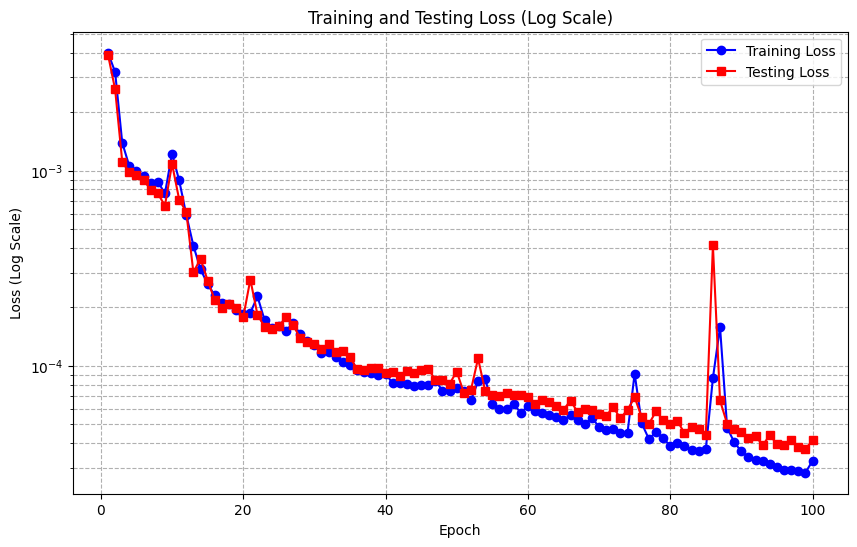

In [73]:
from torch.utils.data import Subset

# Initialize Model, Loss, and Optimizer
model = ConditionalUNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Set manual seed for reproducibility
torch.manual_seed(42)

# Generate shuffled indices
indices = torch.randperm(len(dataset)).tolist()

# Split indices into training and testing
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Create datasets using Subset
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Track Training and Testing Loss
train_losses = []
test_losses = []

# Training Loop
num_epochs = 100
# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    
    # Training Loop with Progress Bar
    loop = tqdm(train_loader, total=len(train_loader), leave=True)
    for image, label, target in loop:
        # Move data to GPU
        image, label, target = image.to(device), label.to(device), target.to(device)

        optimizer.zero_grad()

        # Forward pass
        prediction = model(image, label)

        # Calculate Loss and Backpropagation
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        running_train_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Average Training Loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on Test Set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for image, label, target in test_loader:
            image, label, target = image.to(device), label.to(device), target.to(device)
            prediction = model(image, label)

            # Calculate Test Loss
            test_loss = criterion(prediction, target)
            running_test_loss += test_loss.item()

    # Average Test Loss
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch [{epoch+1}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot Training and Testing Loss Curves with Log Scale
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o', color='b')
plt.plot(range(1, num_epochs+1), test_losses, label='Testing Loss', marker='s', color='r')

plt.title("Training and Testing Loss (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log Scale)")
plt.yscale('log')  # Apply log scale to y-axis
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

/tmp/ipykernel_641324/4183567099.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_label = torch.tensor(label_tensor[idx], dtype=torch.float32, device=device).view(1, 1)  # Shape: (1, 1)


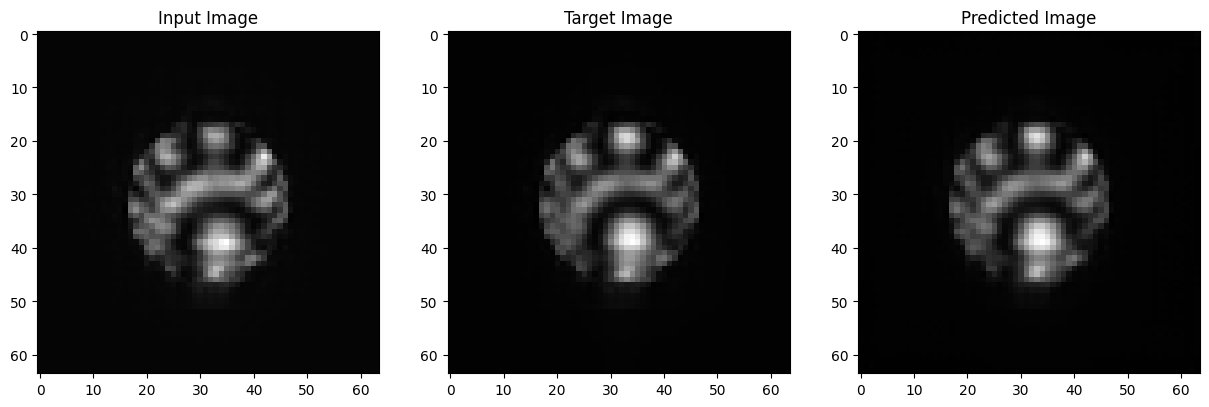

In [74]:
# Switch model to evaluation mode
model.eval()

# Select specific input sample (Use single index)
idx = test_indices[0]  # Index in the reduced 3D dataset

# Extract corresponding input, label, and target
sample_input = input_tensor[idx].unsqueeze(0).unsqueeze(0).to(device)  # Shape: (1, 1, 64, 64)
sample_label = torch.tensor(label_tensor[idx], dtype=torch.float32, device=device).view(1, 1)  # Shape: (1, 1)

# Make a prediction
with torch.no_grad():
    prediction = model(sample_input, sample_label)
    pred_img = prediction.squeeze().cpu().numpy()

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original Input
ax[0].imshow(sample_input.squeeze().cpu().numpy(), cmap='gray')
ax[0].set_title("Input Image")

# Ground Truth (Assuming output_tensor is available)
target_img = output_tensor[idx].cpu().numpy()
ax[1].imshow(target_img, cmap='gray')
ax[1].set_title("Target Image")

# Predicted Output
ax[2].imshow(pred_img, cmap='gray')
ax[2].set_title("Predicted Image")

plt.show()

In [75]:
import torch

# Switch model to evaluation mode
model.eval()

# Initialize tensors for storing predictions, inputs, and targets
num_samples = len(test_loader.dataset)
predictions = torch.zeros(num_samples, 64, 64)
input_images = torch.zeros(num_samples, 64, 64)
target_images = torch.zeros(num_samples, 64, 64)

# Evaluate all test samples
with torch.no_grad():
    start_idx = 0
    for image, label, target in test_loader:
        # Move data to device
        image, label, target = image.to(device), label.to(device), target.to(device)

        # Make prediction
        prediction = model(image, label)

        # Calculate the batch size
        batch_size = prediction.size(0)

        # Save predictions, inputs, and targets batch-wise
        predictions[start_idx : start_idx + batch_size] = prediction.squeeze(1).cpu()
        input_images[start_idx : start_idx + batch_size] = image.squeeze(1).cpu()
        target_images[start_idx : start_idx + batch_size] = target.squeeze(1).cpu()

        # Update the starting index
        start_idx += batch_size

# Save tensors to files
torch.save(predictions, "test_predictions_tensor.pt")
torch.save(input_images, "test_input_images_tensor.pt")
torch.save(target_images, "test_target_images_tensor.pt")

# Verify tensor shapes
print(f"Saved Predictions Shape: {predictions.shape}")
print(f"Saved Input Images Shape: {input_images.shape}")
print(f"Saved Target Images Shape: {target_images.shape}")


Saved Predictions Shape: torch.Size([130, 64, 64])
Saved Input Images Shape: torch.Size([130, 64, 64])
Saved Target Images Shape: torch.Size([130, 64, 64])


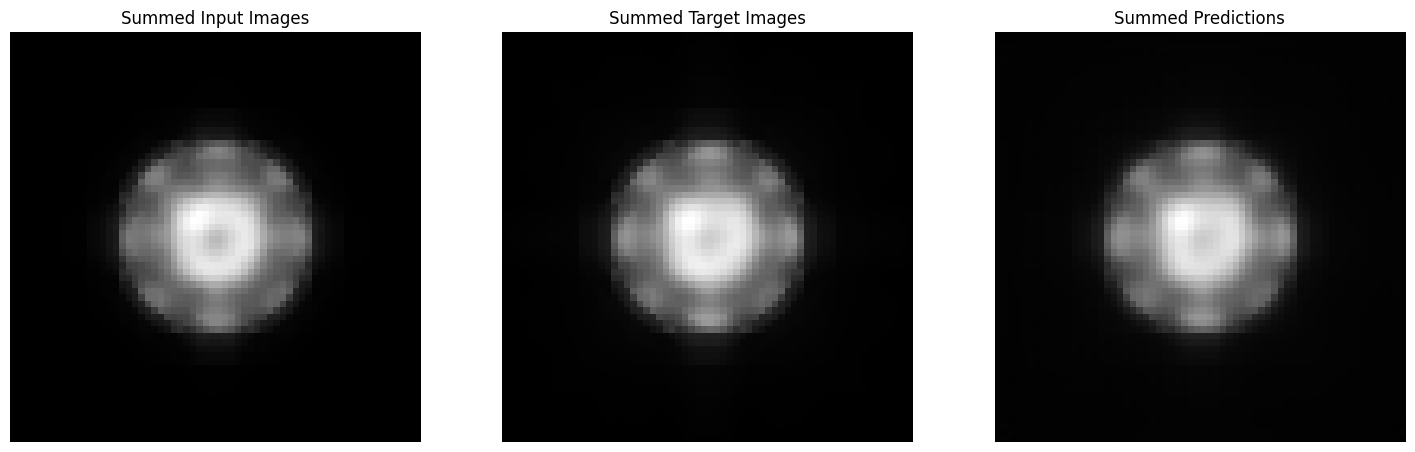

In [76]:
import torch
import matplotlib.pyplot as plt

# Load tensors
predictions = torch.load("test_predictions_tensor.pt")
input_images = torch.load("test_input_images_tensor.pt")
target_images = torch.load("test_target_images_tensor.pt")

# Sum along dimension 0
summed_predictions = predictions.sum(dim=0)
summed_input_images = input_images.sum(dim=0)
summed_target_images = target_images.sum(dim=0)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot summed input images
ax[0].imshow(summed_input_images.numpy(), cmap='gray')
ax[0].set_title("Summed Input Images")
ax[0].axis("off")

# Plot summed target images
ax[1].imshow(summed_target_images.numpy(), cmap='gray')
ax[1].set_title("Summed Target Images")
ax[1].axis("off")

# Plot summed predictions
ax[2].imshow(summed_predictions.numpy(), cmap='gray')
ax[2].set_title("Summed Predictions")
ax[2].axis("off")

plt.show()
